In [1]:
from __future__ import division, print_function
import numpy, pylab, math
import icecube
from icecube import dataio
from icecube import dataclasses
from icecube import CascadeVariables
import os
%matplotlib inline

In [2]:
#Set the GCD to use
gcd=dataio.I3File("/data/sim/IceCube/2011/filtered/level2/neutrino-generator/10099/00000-00999/GeoCalibDetectorStatus_IC86.55697_corrected_V2.i3.gz")

#Extract geometry object
gcd.rewind()
fr=gcd.pop_frame()
geo=fr.Get("I3Geometry")

In [3]:
#Load files
NFiles=100
sigFilesI3=[]
sigDir="/data/user/dxu/batch/myjobs/EHE/level4a/cc_nutau/10099/outfile_reOP/update_07122016/"
sigFiles=os.listdir(sigDir)
for i in sigFiles:
    if(i.find(".i3.bz2")>0):
        sigFilesI3.append(i)

sigFilesI3=sigFilesI3[0:NFiles]

In [4]:
#Load the profiles
import cPickle
KernelsFile=open("DOMKernelsLong.dat",'r')
WFDictionary=cPickle.load(KernelsFile)



In [115]:
#Extract the waveforms and distances
Count=0    
Distances=[]
Waveforms=[]
Energies=[]
Times=[]
Charges=[]
MaxWFTimes=[]
BinWidths=[]

EnergyLimLow=5e3
EnergyLimHigh=1e6

for sgFile in sigFilesI3[0:1]:
    Count=Count+1
    print("opening "+sgFile+",  "+str(Count)+" of " + str(len(sigFilesI3)))
    sigFile=dataio.I3File(sigDir+sgFile)
    sigFile.rewind()
    while(sigFile.more()):
        #pop a frame
        fr=sigFile.pop_physics()

        #grab the weight dict and event weight
        WeightDict=fr.Get("I3MCWeightDict")
        Weight=(365*24*3600)*1.0e-8*pow(WeightDict["PrimaryNeutrinoEnergy"], -2)*WeightDict["OneWeight"]/(WeightDict["NEvents"]*len(sigFilesI3))

        #Find the cascade center
        if not fr.Has("CascadeLlhVertexFit") :
            continue

        if( WeightDict["PrimaryNeutrinoEnergy"]<EnergyLimLow) or (WeightDict["PrimaryNeutrinoEnergy"]>EnergyLimHigh):    
            continue
        csc=fr.Get('CascadeLlhVertexFit')
        cscpos=csc.pos

        wf=fr.Get('CalibratedWaveformsHLCATWD')
        DistancesThisEvt=[]
        WaveformsThisEvt=[]
        EnergiesThisEvt=[]
        TimesThisEvt=[]
        ChargesThisEvt=[]
        BinWidthsThisEvt=[]
        for om, wf_series in wf:
            for w in wf_series:
                if(w.status==0):
                    DOMPos=geo.omgeo[om].position
                    DistancesThisEvt.append((cscpos-DOMPos).r)
                    WaveformsThisEvt.append(w.waveform)
                    TimesThisEvt.append(w.time)
                    ChargesThisEvt.append(sum(w.waveform))
                    BinWidthsThisEvt.append(w.bin_width)
                    break
        Energies.append(csc.energy)
        Distances.append(DistancesThisEvt)
        Waveforms.append(WaveformsThisEvt)
        Charges.append(ChargesThisEvt)
        Times.append(TimesThisEvt)
        BinWidths.append(BinWidthsThisEvt)
        MaxWFTimes.append(TimesThisEvt[numpy.argmax(ChargesThisEvt)])

    sigFile.close()

opening dp_Level4a_nugen_nutau_IC86.2011.010099.000200.i3.bz2,  1 of 100


In [116]:
#Extract the time shifts
TimeShifts=[]
for tindex in range(0,len(Times)):
    StartTime=numpy.min(Times[tindex])
    TimeShifts.append((Times[tindex]-StartTime)/BinWidths[tindex])
    

In [117]:
#This function applies the template matching
def MakeTemplateMatch(Waveform,Kernel):
    buffers=[]
    for istart in range(len(Waveform),0,-1):
        buff=numpy.zeros(istart)
        thebuffer=numpy.sum(numpy.concatenate((buff,Kernel))*numpy.concatenate((Waveform,buff)))
        buffers.append(thebuffer) 

    for istart in range(0,len(Waveform)):
        buff=numpy.zeros(istart)
        thebuffer=numpy.sum(numpy.concatenate((buff, Waveform))*numpy.concatenate((Kernel,buff)))
        buffers.append(thebuffer) 
    return buffers

0
1
2
3
4
5
6
7
8
9


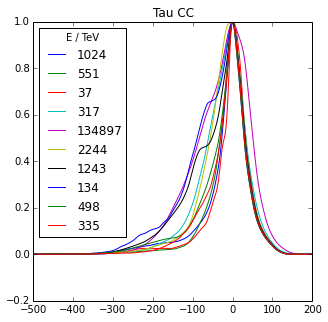

In [118]:
# Try it for a few waveforms 
DistanceLims=KernelDictionary.keys()
WFLength=1000
Offset=0
todo=10
pylab.figure(figsize=(5,5))

for evt in range(0,len(Waveforms[0:todo])):
    SumCorrel=numpy.zeros(2.*WFLength)
    for wf in range(0,len(Waveforms[evt])):
        Shift=int(TimeShifts[evt][wf])+Offset
        Kernel=None


        for dis in range(0,len(DistanceLims)-1):
            if(DistanceLims[dis]<Distances[evt][wf] and DistanceLims[dis+1]>Distances[evt][wf]) and len(Waveforms[evt][wf])==128:
                Kernel=WFDictionary[DistanceLims[dis]]
                break
        if(Kernel==None):
            continue
        if(Shift>WFLength):
            continue

        ToMatchWF=numpy.zeros(WFLength)

        for w in range(0,min(128,(WFLength-Shift))):
            ToMatchWF[w+Shift]+=numpy.array(Waveforms[evt][wf][w])
        SumCorrel+=MakeTemplateMatch(ToMatchWF,Kernel)
    print(evt)
    peak=numpy.argmax(SumCorrel)
    pylab.plot(range(0-peak,len(SumCorrel)-peak),SumCorrel/max(SumCorrel),label=str(int(Energies[evt]/1000)))
    pylab.legend(loc='upper left',title='E / TeV')
    pylab.title("Tau CC")
    pylab.xlim(-500,200)

    
